In [1]:
# Averages for each species
## Authors: Marcela Hernández and Esteban Soto
### CICIMA UCR

#### This script takes a list of species and creates a graph with its average spectra and std for each datapoint

conda install pandas, matplotlib

In [2]:
import sys
import os

# Get the current directory
current_directory = os.getcwd()

# Add the current directory to the Python path
sys.path.append(current_directory)
print(current_directory)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import re
import scipy
import tensorflow as tf
import seaborn as sns
import metrics
import socket #gets the machine name

#functionality to reload modules
import importlib
import spectraltools
# clear the import cache
importlib.reload(metrics)
importlib.reload(spectraltools)
# now you can import my_class and it'll be updated
from metrics import *
from spectraltools import *

#To avoid tf from crashing
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


C:\Users\esteb\cicima\escarabajos\gamma


In [3]:
"""This section allows the user to choose their workplace location.
This is important if the user has multiple locations and operating systems in which this 
script is run"""

#Training data is used when we are already certain of species and genera for a particular sample
training_data_is_used = False

if socket.gethostname() == "colaboratory":
  from google.colab import drive
  drive.mount("/content/drive")
  #base folder
  """Select the location for your base folder"""
    
  base_folder = r"/content/drive/My Drive/CICIMA/escarabajos_files"
  
elif socket.gethostname() == "Shannon":

    """Select the location of your base folder"""
    base_folder = r"C:\Users\esteb\cicima\escarabajos"

elif socket.gethostname() == "CICIMA-EVSM":
  
    """Select the location of your base folder"""
    base_folder = r"C:\Users\EstebanSoto\Jupyter\escarabajos"

elif socket.gethostname() == "cicima_laptop":
    
    """Select the location of your base folder"""
    base_folder = r"/home/vinicio/escarabajos"

#define the location of the tables with information about the collections and its parent directory

collection_tables_main_path =  os.path.join(base_folder, "L1050_data","collections")
collection_files_main_path = os.path.join(base_folder, "L1050_data")

# Define report location
report_location = os.path.join(base_folder, "reports","data_analysis")

#collection_descriptor = r"CICIMAUCR and ANGSOL" tododelete

#File location and metadata location for collection 1
angsol_collection_path = os.path.join(collection_files_main_path,"ANGSOL","average") 
angsol_collection_metadata = os.path.join(collection_tables_main_path,"CICIMA-beetles-general-inventory - ANGSOL.txt") 

#File location and metadata location for collection 2
cicimaucr_collection_path = os.path.join(collection_files_main_path,r"TRA_data_CICIMA_INBUCR","CICIMAUCR","reflectance")  #listo
cicimaucr_collection_2_path = os.path.join(collection_files_main_path,r"CICIMA-2024-01-REFLECTANCE","average")
cicimaucr_collection_3_path = os.path.join(collection_files_main_path,r"CICIMA-2024-03-REFLECTANCE","without iris nor lens","average")
cicimaucr_collection_4_path = os.path.join(collection_files_main_path,r"CICIMA-2024-05-REFLECTANCE", "DORSAL","average")
#cicimaucr_collection_4_path = os.path.join(collection_files_main_path,r"CICIMA-2024-05-REFLECTANCE", "VENTRAL","average")
cicima_ucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - CICIMAUCR.txt") 

#File location and metadata location for collection 3
inbucr_collection_path = os.path.join(collection_files_main_path,r"INBUCR","average") #listo
inbucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - INBUCR.txt") 

#File location and metadata location for collection 4
bioucr_collection_path = os.path.join(collection_files_main_path,r"BIOUCR","average")  #listo
bioucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - BIOUCR.txt") 

#agregated data location, here averages and std will be saved when training data and retreived when classifying spectra
agregated_data_location = os.path.join(base_folder, "aggregated_data")

In [4]:
#Collections
angsol_collection = Specimen_Collection("ANGSOL", angsol_collection_path, angsol_collection_metadata, "HIGH")
angsol_collection.set_description("ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high.")

cicimaucr_collection = Specimen_Collection("CICIMAUCR1", cicimaucr_collection_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR2", cicimaucr_collection_2_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR3", cicimaucr_collection_3_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_3.set_description("""The most part of CICIMA specimens belongs to this collecttion""")

cicimaucr_collection_4 = Specimen_Collection("CICIMAUCR4", cicimaucr_collection_4_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_4.set_description("""This collection has kalinini and resplendens specimens which were not used in training. 
                                        These are intended to be used as test subjects""")

inbucr_collection = Specimen_Collection("INBUCR", inbucr_collection_path, inbucr_metadata, "MID")
bioucr_collection = Specimen_Collection("BIOUCR", bioucr_collection_path, bioucr_metadata, "LOW")

collection_list = [
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    cicimaucr_collection_4,
                    inbucr_collection,
                    #bioucr_collection,
                    ]
collection_names_set = set([collection.name for collection in collection_list])
collection_names = " ".join( sorted(collection_names_set))

prediction_list = [
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    cicimaucr_collection_4,
                    inbucr_collection,
                    bioucr_collection,
                    ]
prediction_collection_names_set = set([collection.name for collection in collection_list])
prediction_collection_names = " ".join( sorted(collection_names_set))


#print(collection_names)
#date
from datetime import datetime
current_date = datetime.now().date()

def get_filtered_spectra(collection_list):

    all_spectra = []
    
    for collection in collection_list:
        all_spectra += collection.get_spectra()

    all_spectra = [item for item in all_spectra if item.get_species() in ["kalinini", "resplendens", "cupreomarginata"]]
    all_spectra =  [item for item in all_spectra if item.code not in ["CICIMAUCR0070"]]
    return all_spectra
    
def get_spectra(collection_list):

    all_spectra = []
    
    for collection in collection_list:
        all_spectra += collection.get_spectra()

    return all_spectra  
    
training_spectra = get_filtered_spectra(collection_list)
prediction_spectra  = get_spectra(prediction_list) 

for spectrum in prediction_spectra:
    #print(spectrum.get_species())
    pass

training_spectra

File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0001.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0002.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0003.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0004.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0005.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0006.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0007.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0008.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0009.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0010.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0011.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0012.txt
File: C:\Users\esteb\cicima\

#### System Information

In [5]:
import sys

float_info = sys.float_info
print("Floating point representation information:")
print("-----------------------------------------------------")
print("Smallest representable positive number:", float_info.min)
print("Largest representable finite number:", float_info.max)
print("Smallest positive x for which 1.0 + x != 1.0:", float_info.epsilon)
print("Number of digits in the significand (precision in digits):", float_info.dig)
print("Number of base-10 digits in the significand (precision in decimal digits):", float_info.mant_dig)
print("-----------------------------------------------------")

Floating point representation information:
-----------------------------------------------------
Smallest representable positive number: 2.2250738585072014e-308
Largest representable finite number: 1.7976931348623157e+308
Smallest positive x for which 1.0 + x != 1.0: 2.220446049250313e-16
Number of digits in the significand (precision in digits): 15
Number of base-10 digits in the significand (precision in decimal digits): 53
-----------------------------------------------------


In [6]:
def pad_list(lst, filler=0):
    metrics = lst[1]
    
    for metric in metrics:
        #print(metric)
        
        max_length = max([len(list) for list in metrics])
        
        #print(max_length)
        
        padded_list = []

        for element in metrics:

            padded_sublist = element
            
            padded_sublist += [filler] * (max_length - len(padded_sublist))
            padded_list.append(padded_sublist)
            #print(padded_sublist)
    final_list = [lst[0], (padded_list), lst[2]]
    return final_list

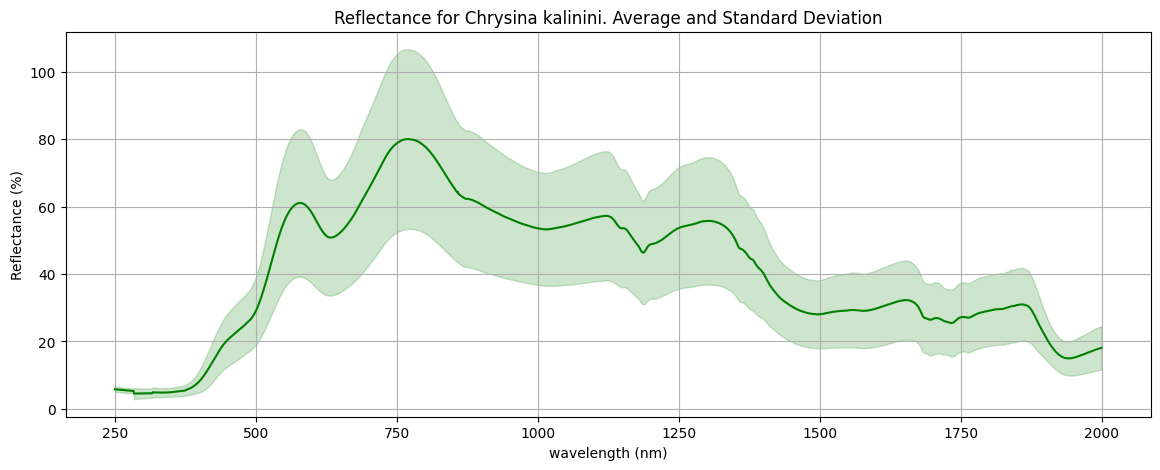

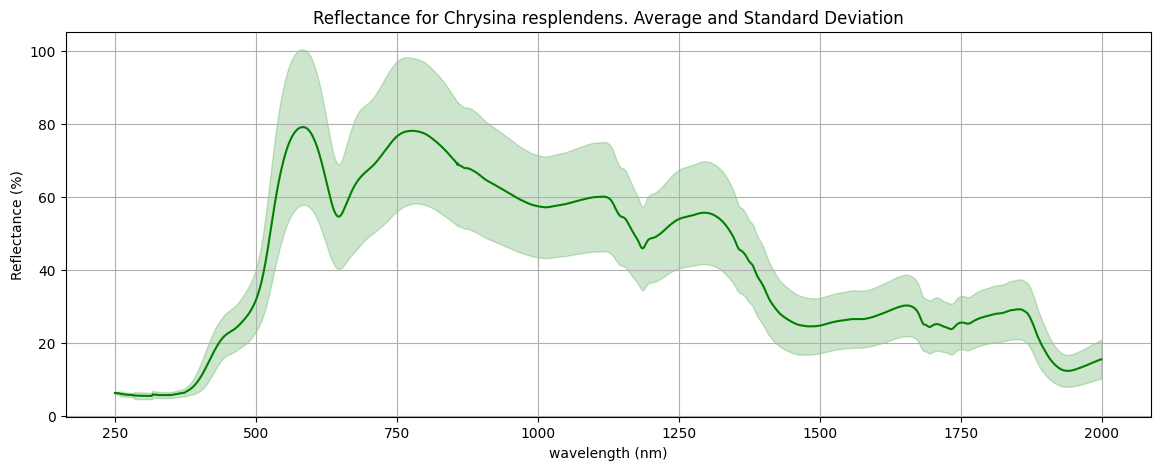

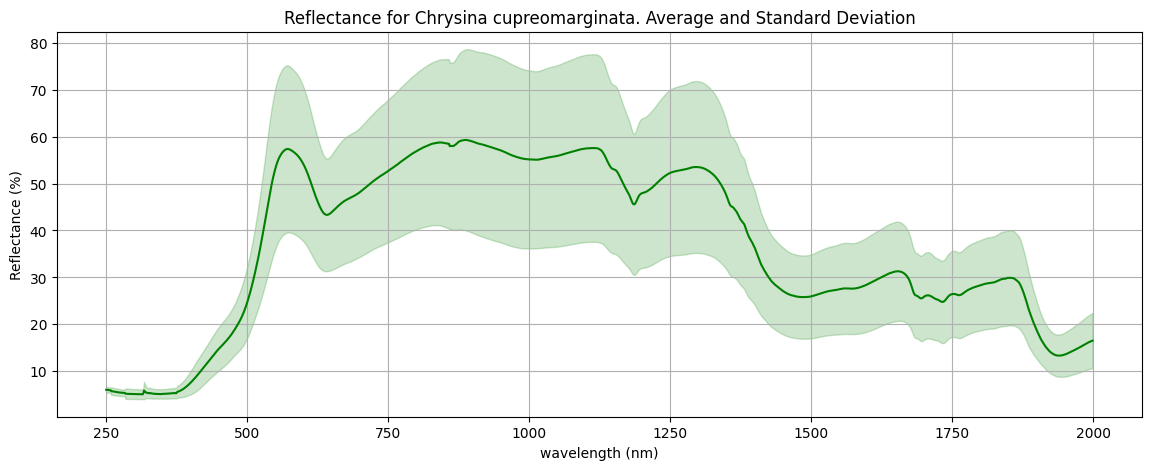

In [35]:
### Define species list
species_list = ["kalinini","resplendens", "cupreomarginata"]
for species in species_list:
   
    condition_1 = lambda spectrum, needed_species: spectrum.species == needed_species
    #print(training_spectra[0].data)
    #condition_2 = lambda spectrum: min(spectrum.data["wavelength"]) > 250
    condition_3 = lambda spectrum: max(spectrum.data["wavelength"]) > 250
    filtered_set = [spectrum.data for spectrum in training_spectra if (condition_1(spectrum, species) & condition_3(spectrum))]

    #Now calculate average and std for the filtered set
    #convert a filtered set of dataframes to a dataframe
    filtered_combined_df = pd.concat(filtered_set, ignore_index=True)

    #print(filtered_combined_df)
    average = filtered_combined_df.groupby('wavelength', as_index=False)['%R'].mean()
    std = filtered_combined_df.groupby('wavelength', as_index=False)['%R'].std()

    #print(average)
    #print(std)

    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    plt.figure(figsize = (14,5))
    sns.lineplot(x='wavelength', y='%R', data=filtered_combined_df, 
                 estimator=np.mean, errorbar='sd', color = "green")
    plt.title(f'Reflectance for Chrysina {species}. Average and Standard Deviation')
    plt.xlabel('wavelength (nm)')
    plt.ylabel('Reflectance (%)')
    plt.grid()
    plt.savefig(f'C. {species} avg and std plot.png', dpi=300, bbox_inches='tight')
    #plt.show()
    